# Physics-Informed DeepONet for 1D Poisson Equation

**Learning Objectives:**
- Understand how to incorporate physics constraints into DeepONet training
- Implement soft-constrained physics-informed DeepONet (PI-DeepONet)
- Apply PI-DeepONet to the 1D Poisson equation with Dirichlet boundary conditions
- Compare physics-informed vs data-driven approaches

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml-sciml/blob/main/docs/02-deeponet/pideeponet-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml-sciml/blob/main/docs/02-deeponet/pideeponet.ipynb)


**Slides:** [![View PDF](https://img.shields.io/badge/View-PDF-red?style=flat-square&logo=googledocs&logoColor=white)](https://github.com/kks32-courses/sciml-sciml/raw/main/docs/02-deeponet/deeponet-slides.pdf)

**Problem:** Learn the solution operator for the 1D Poisson equation:
$$\frac{d^2u}{dx^2} = -f(x), \quad x \in [0,1]$$
with Dirichlet boundary conditions: $u(0) = 0$, $u(1) = 0$

**Physics-Informed Approach:** Incorporate the differential equation and boundary conditions directly into the loss function.

---

In [7]:
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from scipy.integrate import solve_bvp

warnings.filterwarnings('ignore')

# Set style and random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: mps


## Problem Setup: 1D Poisson Equation

### Mathematical Formulation

We want to learn the solution operator $\mathcal{G}$ that maps source functions $f(x)$ to solutions $u(x)$:

$$\mathcal{G}[f] = u$$

where $u(x)$ satisfies:
- **PDE:** $\frac{d^2u}{dx^2} = -f(x)$ for $x \in [0,1]$
- **Boundary conditions:** $u(0) = 0$, $u(1) = 0$

### Physics-Informed Loss Components

1. **Data Loss:** $\mathcal{L}_{data} = \frac{1}{N} \sum_{i=1}^N \|u_{pred}^{(i)} - u_{true}^{(i)}\|^2$

2. **Physics Loss:** $\mathcal{L}_{physics} = \frac{1}{N} \sum_{i=1}^N \left\|\frac{d^2u_{pred}^{(i)}}{dx^2} + f^{(i)}\right\|^2$

3. **Boundary Loss:** $\mathcal{L}_{boundary} = \frac{1}{N} \sum_{i=1}^N \left[|u_{pred}^{(i)}(0)|^2 + |u_{pred}^{(i)}(1)|^2\right]$

4. **Total Loss:** $\mathcal{L} = \mathcal{L}_{data} + \lambda_{physics} \mathcal{L}_{physics} + \lambda_{boundary} \mathcal{L}_{boundary}$

![PI DeepONet](figs/pideeponet-arch.png)

=== GENERATING POISSON DATA ===
Generating 1000 Poisson solutions...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10623.63it/s]

Generated 1000 function pairs
Domain: x ∈ [0, 1] with 100 points
Source functions shape: (1000, 100)
Solutions shape: (1000, 100)


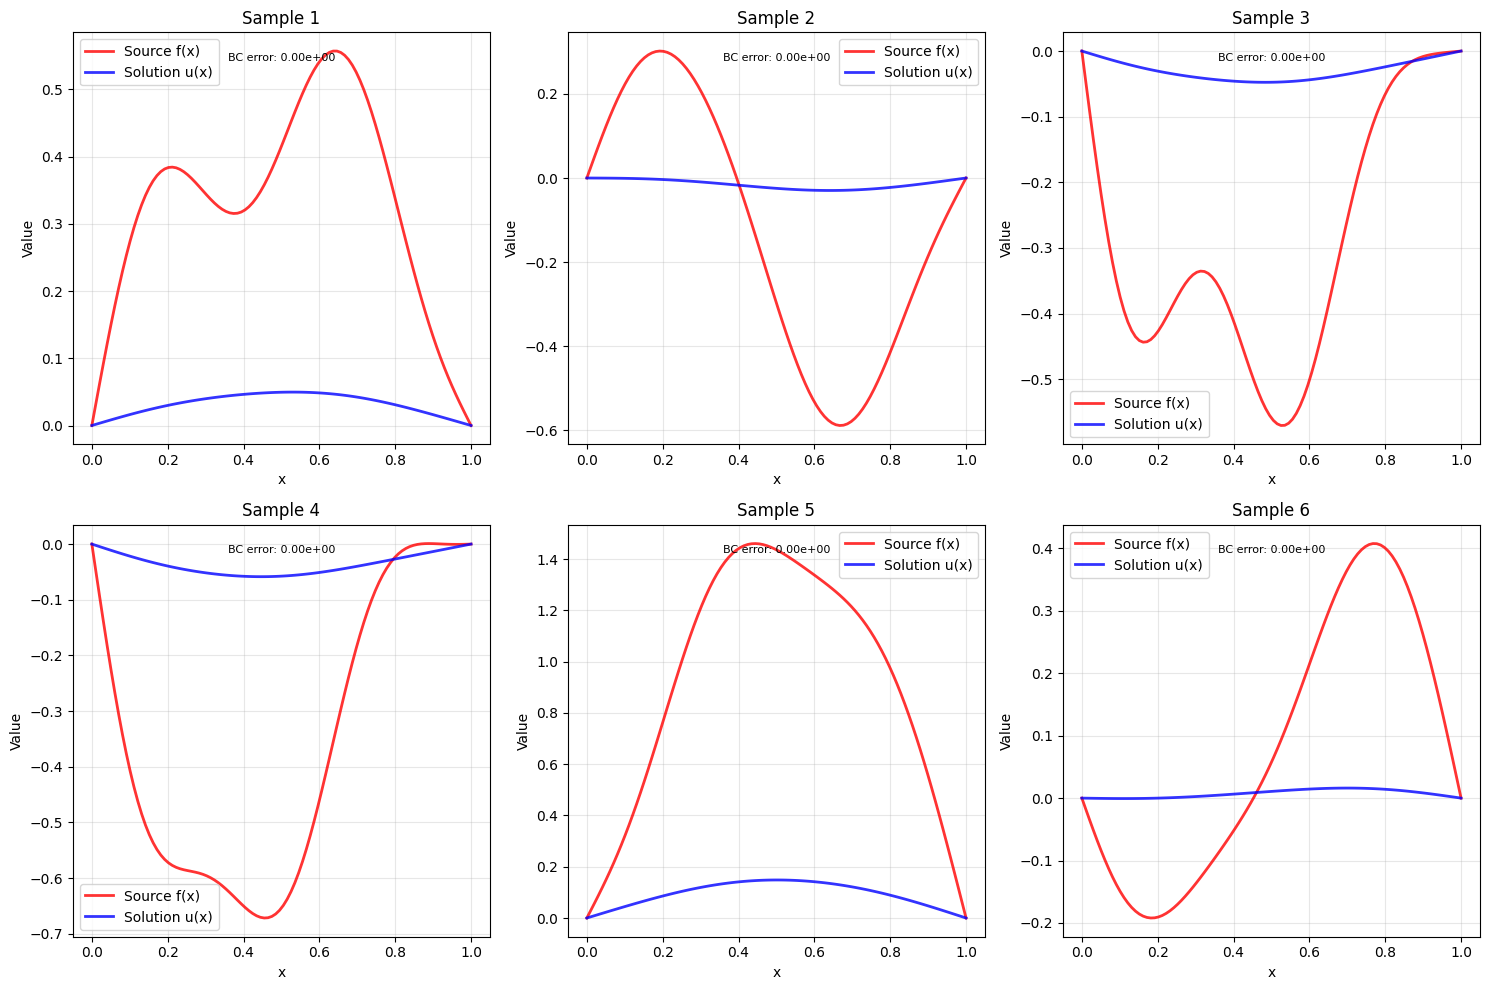


Verification:
Boundary conditions satisfied: u(0) = 0.000000, u(1) = 0.000000
Max solution value: 0.396588


In [8]:
# ========================= DATA GENERATION =========================
def generate_source_functions(num_functions=1000, num_points=100):
    """Generate random source functions f(x) using Fourier series"""
    x = np.linspace(0, 1, num_points)
    functions = np.zeros((num_functions, num_points))
    
    for i in range(num_functions):
        # Create f(x) using Fourier series with random coefficients
        f = np.zeros_like(x)
        
        # Add sine modes (automatically satisfy boundary conditions)
        for n in range(1, 6):  # Use first 5 modes
            coeff = np.random.normal(0, 1/(n**2))  # Decay with mode number
            f += coeff * np.sin(n * np.pi * x)
        
        functions[i] = f
    
    return x, functions

def solve_poisson_1d(x, f):
    """Solve 1D Poisson equation using finite differences"""
    n = len(x)
    dx = x[1] - x[0]
    
    # Create finite difference matrix for d²u/dx²
    # Interior points: u[i-1] - 2*u[i] + u[i+1] = dx² * (-f[i])
    A = np.zeros((n-2, n-2))
    b = np.zeros(n-2)
    
    for i in range(n-2):
        A[i, i] = -2.0 / (dx**2)
        if i > 0:
            A[i, i-1] = 1.0 / (dx**2)
        if i < n-3:
            A[i, i+1] = 1.0 / (dx**2)
        b[i] = -f[i+1]  # RHS: -f(x)
    
    # Solve for interior points
    u_interior = np.linalg.solve(A, b)
    
    # Construct full solution (boundary conditions u(0)=0, u(1)=0)
    u = np.zeros(n)
    u[1:-1] = u_interior
    
    return u

def generate_poisson_data(num_functions=1000, num_points=100):
    """Generate dataset for 1D Poisson equation"""
    x, source_functions = generate_source_functions(num_functions, num_points)
    solutions = np.zeros_like(source_functions)
    
    print(f"Generating {num_functions} Poisson solutions...")
    for i in tqdm(range(num_functions)):
        solutions[i] = solve_poisson_1d(x, source_functions[i])
    
    return x, source_functions, solutions

print("=== GENERATING POISSON DATA ===")
x, source_functions, solutions = generate_poisson_data(num_functions=1000, num_points=100)

print(f"Generated {len(source_functions)} function pairs")
print(f"Domain: x ∈ [0, 1] with {len(x)} points")
print(f"Source functions shape: {source_functions.shape}")
print(f"Solutions shape: {solutions.shape}")

# Visualize sample data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax = axes[i//3, i%3]
    
    ax.plot(x, source_functions[i], 'r-', linewidth=2, label='Source f(x)', alpha=0.8)
    ax.plot(x, solutions[i], 'b-', linewidth=2, label='Solution u(x)', alpha=0.8)
    
    ax.set_title(f'Sample {i+1}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('Value')
    
    # Verify boundary conditions
    u_boundary_error = abs(solutions[i][0]) + abs(solutions[i][-1])
    ax.text(0.5, 0.95, f'BC error: {u_boundary_error:.2e}', 
            transform=ax.transAxes, ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()

print("\nVerification:")
print(f"Boundary conditions satisfied: u(0) = {solutions[0][0]:.6f}, u(1) = {solutions[0][-1]:.6f}")
print(f"Max solution value: {np.max(np.abs(solutions)):.6f}")

## Physics-Informed DeepONet Architecture

### Key Modifications from Standard DeepONet

1. **Automatic Differentiation:** Use PyTorch's autograd to compute derivatives
2. **Physics Loss:** Incorporate PDE residual into training
3. **Boundary Enforcement:** Soft constraints for boundary conditions
4. **Multi-objective Loss:** Balance data fidelity and physics consistency

In [9]:
class PhysicsInformedDeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64, num_basis=50):
        super(PhysicsInformedDeepONet, self).__init__()
        self.num_basis = num_basis
        self.hidden_dim = hidden_dim
        
        # Branch network - processes source functions f(x)
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Trunk network - processes spatial coordinates
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, branch_input, trunk_input):
        """Forward pass through PI-DeepONet"""
        # Branch network output
        branch_out = self.branch_net(branch_input)  # [batch_size, num_basis]
        
        # Trunk network output
        if trunk_input.dim() == 3:  # [batch_size, num_points, 1]
            batch_size, num_points, _ = trunk_input.shape
            trunk_input_flat = trunk_input.view(-1, 1)
            trunk_out = self.trunk_net(trunk_input_flat)
            trunk_out = trunk_out.view(batch_size, num_points, self.num_basis)
        else:  # [num_points, 1]
            trunk_out = self.trunk_net(trunk_input)
            trunk_out = trunk_out.unsqueeze(0)
        
        # Compute inner product: sum over basis functions
        output = torch.einsum('bi,bpi->bp', branch_out, trunk_out)
        
        return output + self.bias
    
    def compute_derivatives(self, branch_input, trunk_input):
        """Compute second derivative d²u/dx² using automatic differentiation"""
        # Ensure trunk_input requires gradient
        trunk_input = trunk_input.clone().detach().requires_grad_(True)
        
        # Forward pass
        u = self.forward(branch_input, trunk_input)
        
        # Compute first derivative du/dx
        du_dx = torch.autograd.grad(
            outputs=u,
            inputs=trunk_input,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # Compute second derivative d²u/dx²
        d2u_dx2 = torch.autograd.grad(
            outputs=du_dx,
            inputs=trunk_input,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True,
            retain_graph=True
        )[0]
        
        return u, du_dx, d2u_dx2

print("\n=== PHYSICS-INFORMED DEEPONET ARCHITECTURE ===")
pi_model = PhysicsInformedDeepONet(
    branch_input_dim=len(x),  # Source function f(x) sampled at all points
    trunk_input_dim=1,        # Spatial coordinate x
    hidden_dim=64,
    num_basis=50
)
pi_model = pi_model.to(device)

total_params = sum(p.numel() for p in pi_model.parameters())
print(f"PI-DeepONet Architecture:")
print(f"- Branch input: {len(x)} (source function values)")
print(f"- Trunk input: 1 (spatial coordinate)")
print(f"- Hidden dimension: {pi_model.hidden_dim}")
print(f"- Number of basis functions: {pi_model.num_basis}")
print(f"- Total parameters: {total_params:,}")


=== PHYSICS-INFORMED DEEPONET ARCHITECTURE ===
PI-DeepONet Architecture:
- Branch input: 100 (source function values)
- Trunk input: 1 (spatial coordinate)
- Hidden dimension: 64
- Number of basis functions: 50
- Total parameters: 21,413


## Physics-Informed Training

### Multi-Component Loss Function

The physics-informed loss combines three components:

1. **Data Loss:** Ensures predictions match true solutions
2. **Physics Loss:** Enforces PDE: $\frac{d^2u}{dx^2} + f(x) = 0$
3. **Boundary Loss:** Enforces boundary conditions: $u(0) = 0$, $u(1) = 0$

In [10]:
def physics_informed_loss(model, source_batch, x_batch, u_true_batch, 
                         lambda_physics=1.0, lambda_boundary=1.0, compute_physics=True):
    """Compute physics-informed loss with multiple components"""
    
    if compute_physics:
        # Ensure x_batch requires gradients for automatic differentiation
        x_batch = x_batch.clone().detach().requires_grad_(True)
        
        # Forward pass with derivatives
        u_pred, du_dx, d2u_dx2 = model.compute_derivatives(source_batch, x_batch)
        
        # 1. Data loss: ||u_pred - u_true||²
        data_loss = torch.mean((u_pred - u_true_batch)**2)
        
        # 2. Physics loss: ||d²u/dx² + f||²
        # source_batch is [batch_size, num_points], u_pred is [batch_size, num_points]
        # d2u_dx2 is [batch_size, num_points, 1], need to squeeze last dimension
        d2u_dx2_squeezed = d2u_dx2.squeeze(-1)  # Remove last dimension to match source_batch
        physics_residual = d2u_dx2_squeezed + source_batch
        physics_loss = torch.mean(physics_residual**2)
        
        # 3. Boundary loss: ||u(0)||² + ||u(1)||²
        u_boundary_0 = u_pred[:, 0]   # u(x=0)
        u_boundary_1 = u_pred[:, -1]  # u(x=1)
        boundary_loss = torch.mean(u_boundary_0**2 + u_boundary_1**2)
    else:
        # During validation, only compute data loss to avoid gradient computation issues
        u_pred = model(source_batch, x_batch)
        data_loss = torch.mean((u_pred - u_true_batch)**2)
        physics_loss = torch.tensor(0.0, device=u_pred.device)
        boundary_loss = torch.tensor(0.0, device=u_pred.device)
    
    # Total loss
    total_loss = data_loss + lambda_physics * physics_loss + lambda_boundary * boundary_loss
    
    return total_loss, data_loss, physics_loss, boundary_loss

def setup_pi_data_loaders(source_functions, solutions, x, batch_size=32):
    """Setup data loaders for physics-informed training"""
    # Split data
    train_size = int(0.8 * len(source_functions))
    val_size = int(0.1 * len(source_functions))
    
    train_sources = source_functions[:train_size]
    train_solutions = solutions[:train_size]
    
    val_sources = source_functions[train_size:train_size+val_size]
    val_solutions = solutions[train_size:train_size+val_size]
    
    test_sources = source_functions[train_size+val_size:]
    test_solutions = solutions[train_size+val_size:]
    
    # Convert to tensors
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    
    # Create datasets
    train_x = x_tensor.unsqueeze(0).repeat(len(train_sources), 1, 1)
    val_x = x_tensor.unsqueeze(0).repeat(len(val_sources), 1, 1)
    
    train_dataset = TensorDataset(
        torch.tensor(train_sources, dtype=torch.float32),
        train_x,
        torch.tensor(train_solutions, dtype=torch.float32)
    )
    
    val_dataset = TensorDataset(
        torch.tensor(val_sources, dtype=torch.float32),
        val_x,
        torch.tensor(val_solutions, dtype=torch.float32)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, (test_sources, test_solutions)

def train_physics_informed_deeponet(model, train_loader, val_loader, 
                                  num_epochs=1000, lr=0.001, 
                                  lambda_physics=1.0, lambda_boundary=10.0):
    """Train physics-informed DeepONet"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)
    
    # Storage for losses
    train_losses = {'total': [], 'data': [], 'physics': [], 'boundary': []}
    val_losses = {'total': [], 'data': [], 'physics': [], 'boundary': []}
    
    best_val_loss = float('inf')
    patience = 200
    patience_counter = 0
    
    pbar = tqdm(range(num_epochs), desc="Training PI-DeepONet")
    
    for epoch in pbar:
        # Training
        model.train()
        train_loss_epoch = {'total': 0, 'data': 0, 'physics': 0, 'boundary': 0}
        
        for batch_sources, batch_x, batch_solutions in train_loader:
            batch_sources = batch_sources.to(device)
            batch_x = batch_x.to(device)
            batch_solutions = batch_solutions.to(device)
            
            optimizer.zero_grad()
            
            # Compute full physics-informed loss during training
            total_loss, data_loss, physics_loss, boundary_loss = physics_informed_loss(
                model, batch_sources, batch_x, batch_solutions,
                lambda_physics=lambda_physics, lambda_boundary=lambda_boundary,
                compute_physics=True
            )
            
            total_loss.backward()
            optimizer.step()
            
            train_loss_epoch['total'] += total_loss.item()
            train_loss_epoch['data'] += data_loss.item()
            train_loss_epoch['physics'] += physics_loss.item()
            train_loss_epoch['boundary'] += boundary_loss.item()
        
        # Validation
        model.eval()
        val_loss_epoch = {'total': 0, 'data': 0, 'physics': 0, 'boundary': 0}
        
        # Compute validation loss with physics terms (but allow gradients)
        for batch_sources, batch_x, batch_solutions in val_loader:
            batch_sources = batch_sources.to(device)
            batch_x = batch_x.to(device)
            batch_solutions = batch_solutions.to(device)
            
            # Don't use torch.no_grad() here so we can compute derivatives
            total_loss, data_loss, physics_loss, boundary_loss = physics_informed_loss(
                model, batch_sources, batch_x, batch_solutions,
                lambda_physics=lambda_physics, lambda_boundary=lambda_boundary,
                compute_physics=True
            )
            
            val_loss_epoch['total'] += total_loss.item()
            val_loss_epoch['data'] += data_loss.item()
            val_loss_epoch['physics'] += physics_loss.item()
            val_loss_epoch['boundary'] += boundary_loss.item()
        
        # Average losses
        for key in train_loss_epoch:
            train_loss_epoch[key] /= len(train_loader)
            val_loss_epoch[key] /= len(val_loader)
            train_losses[key].append(train_loss_epoch[key])
            val_losses[key].append(val_loss_epoch[key])
        
        scheduler.step(val_loss_epoch['total'])
        
        # Update progress bar
        pbar.set_postfix({
            'Total': f'{train_loss_epoch["total"]:.2e}',
            'Data': f'{train_loss_epoch["data"]:.2e}',
            'Physics': f'{train_loss_epoch["physics"]:.2e}',
            'Boundary': f'{train_loss_epoch["boundary"]:.2e}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Early stopping
        if val_loss_epoch['total'] < best_val_loss:
            best_val_loss = val_loss_epoch['total']
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch}')
                break
    
    pbar.close()
    return train_losses, val_losses

print("\n=== TRAINING SETUP ===")
train_loader, val_loader, test_data = setup_pi_data_loaders(
    source_functions, solutions, x, batch_size=32
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test samples: {len(test_data[0])}")

print("\nStarting physics-informed training...")
train_losses, val_losses = train_physics_informed_deeponet(
    pi_model, train_loader, val_loader, 
    num_epochs=1000, lr=0.001,
    lambda_physics=1.0, lambda_boundary=10.0
)

print("\nTraining completed!")
print(f"Final losses:")
print(f"  Total: {train_losses['total'][-1]:.2e}")
print(f"  Data: {train_losses['data'][-1]:.2e}")
print(f"  Physics: {train_losses['physics'][-1]:.2e}")
print(f"  Boundary: {train_losses['boundary'][-1]:.2e}")


=== TRAINING SETUP ===
Training batches: 25
Validation batches: 4
Test samples: 100

Starting physics-informed training...


Training PI-DeepONet: 100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s, Total=1.10e-04, Data=1.12e-06, Physics=1.04e-04, Boundary=5.40e-07, LR=1.25e-04]


Training completed!
Final losses:
  Total: 1.10e-04
  Data: 1.12e-06
  Physics: 1.04e-04
  Boundary: 5.40e-07


## Training Analysis and Visualization

### Loss Component Analysis

Understanding how each loss component contributes to the overall training dynamics.

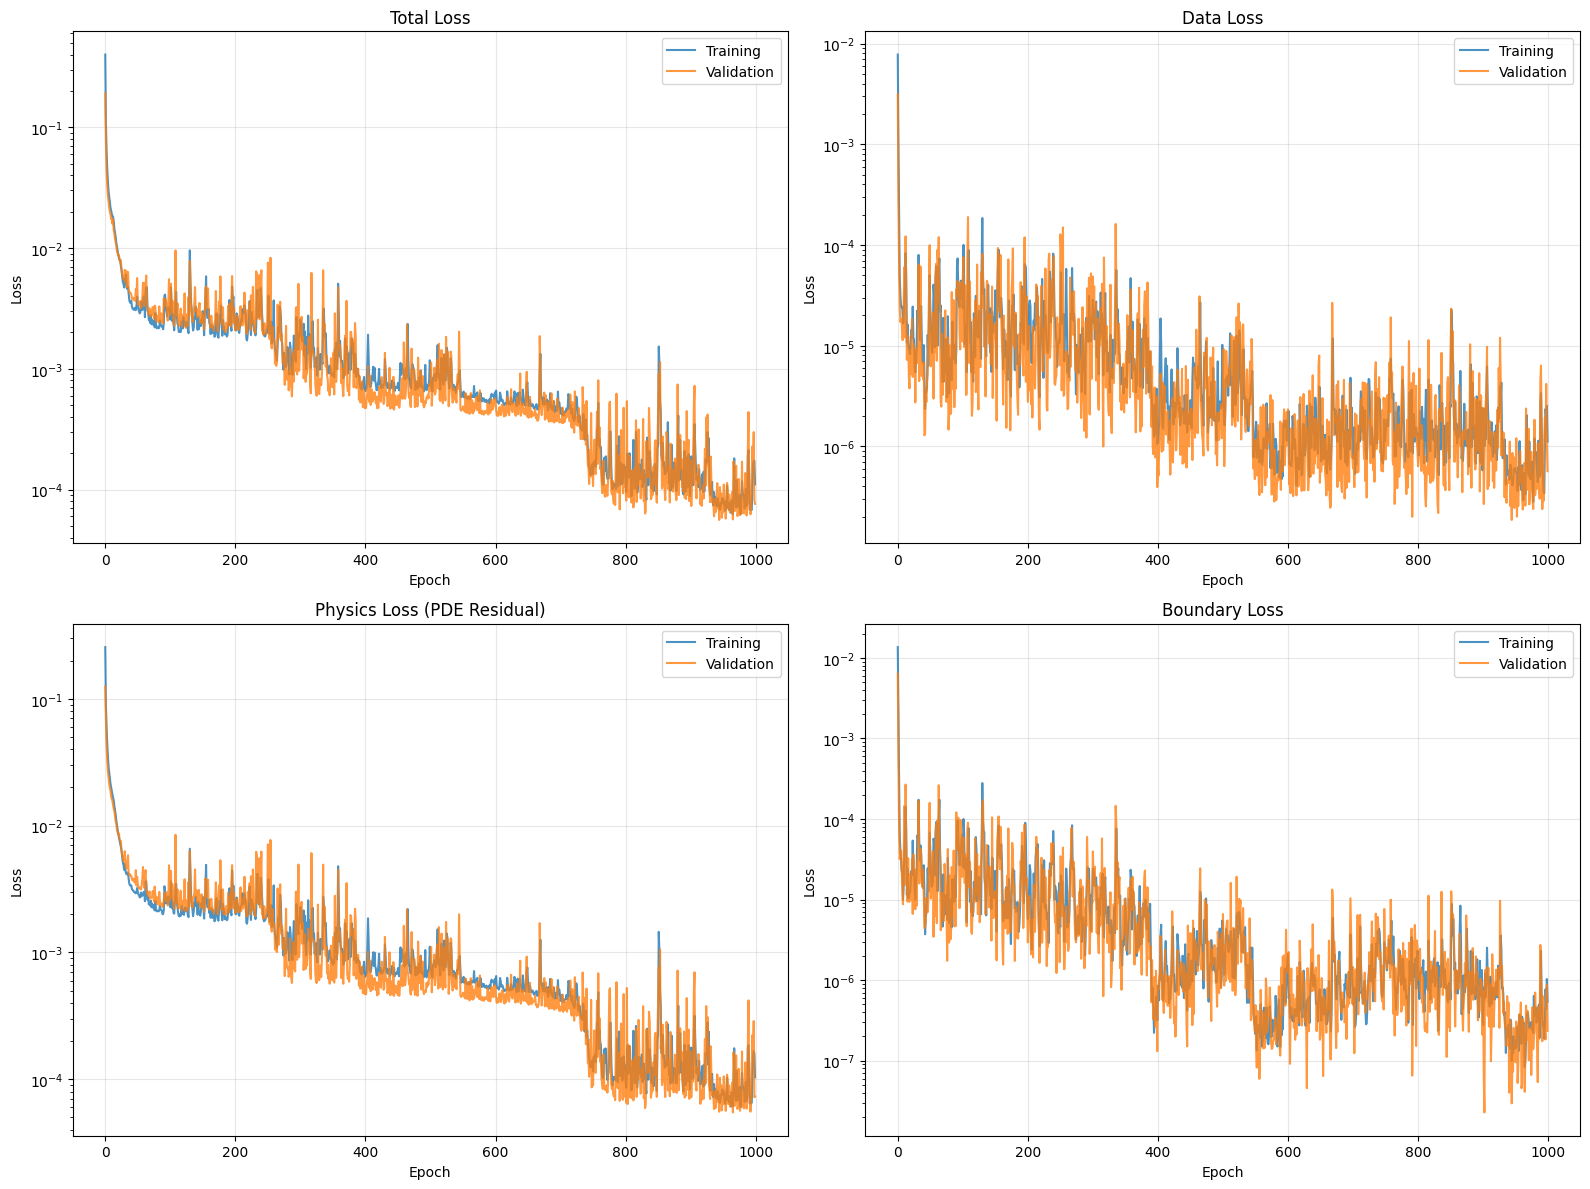

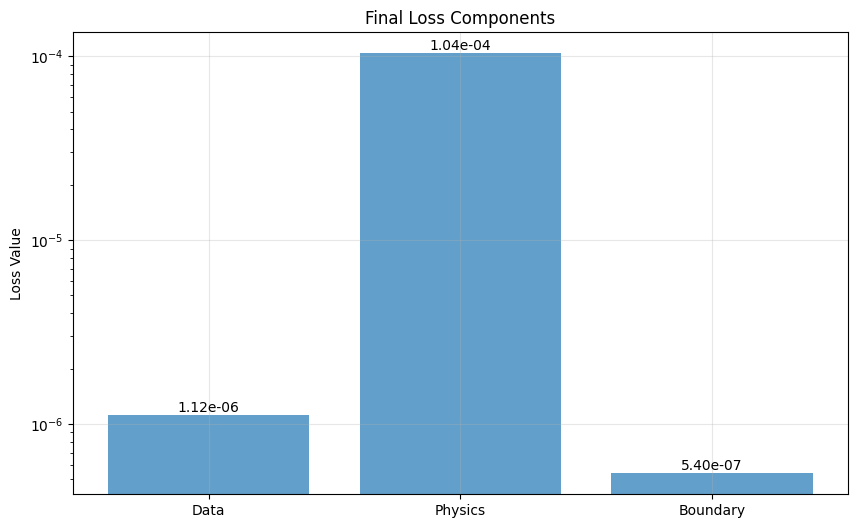

In [14]:
# Plot comprehensive training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total loss
axes[0, 0].plot(train_losses['total'], label='Training', alpha=0.8)
axes[0, 0].plot(val_losses['total'], label='Validation', alpha=0.8)
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Data loss
axes[0, 1].plot(train_losses['data'], label='Training', alpha=0.8)
axes[0, 1].plot(val_losses['data'], label='Validation', alpha=0.8)
axes[0, 1].set_title('Data Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Physics loss
axes[1, 0].plot(train_losses['physics'], label='Training', alpha=0.8)
axes[1, 0].plot(val_losses['physics'], label='Validation', alpha=0.8)
axes[1, 0].set_title('Physics Loss (PDE Residual)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Boundary loss
axes[1, 1].plot(train_losses['boundary'], label='Training', alpha=0.8)
axes[1, 1].plot(val_losses['boundary'], label='Validation', alpha=0.8)
axes[1, 1].set_title('Boundary Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Loss composition at the end of training
final_losses = {
    'Data': train_losses['data'][-1],
    'Physics': train_losses['physics'][-1],
    'Boundary': train_losses['boundary'][-1]
}

plt.figure(figsize=(10, 6))
plt.bar(final_losses.keys(), final_losses.values(), alpha=0.7)
plt.title('Final Loss Components')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.grid(True, alpha=0.3)

for i, (key, value) in enumerate(final_losses.items()):
    plt.text(i, value, f'{value:.2e}', ha='center', va='bottom')

plt.show()

## Model Evaluation and Physics Verification

### Comprehensive Testing

1. **Prediction Accuracy:** How well does the model predict solutions?
2. **Physics Consistency:** Does the model satisfy the PDE?
3. **Boundary Conditions:** Are boundary conditions satisfied?
4. **Generalization:** Performance on unseen data

\n=== MODEL EVALUATION ===
Evaluating 100 test samples...


100%|██████████| 100/100 [00:00<00:00, 405.13it/s]


\nEvaluation Results:
  Average L2 Error: 0.000687
  Average Physics Residual: 0.007279
  Average Boundary Error: 0.000472


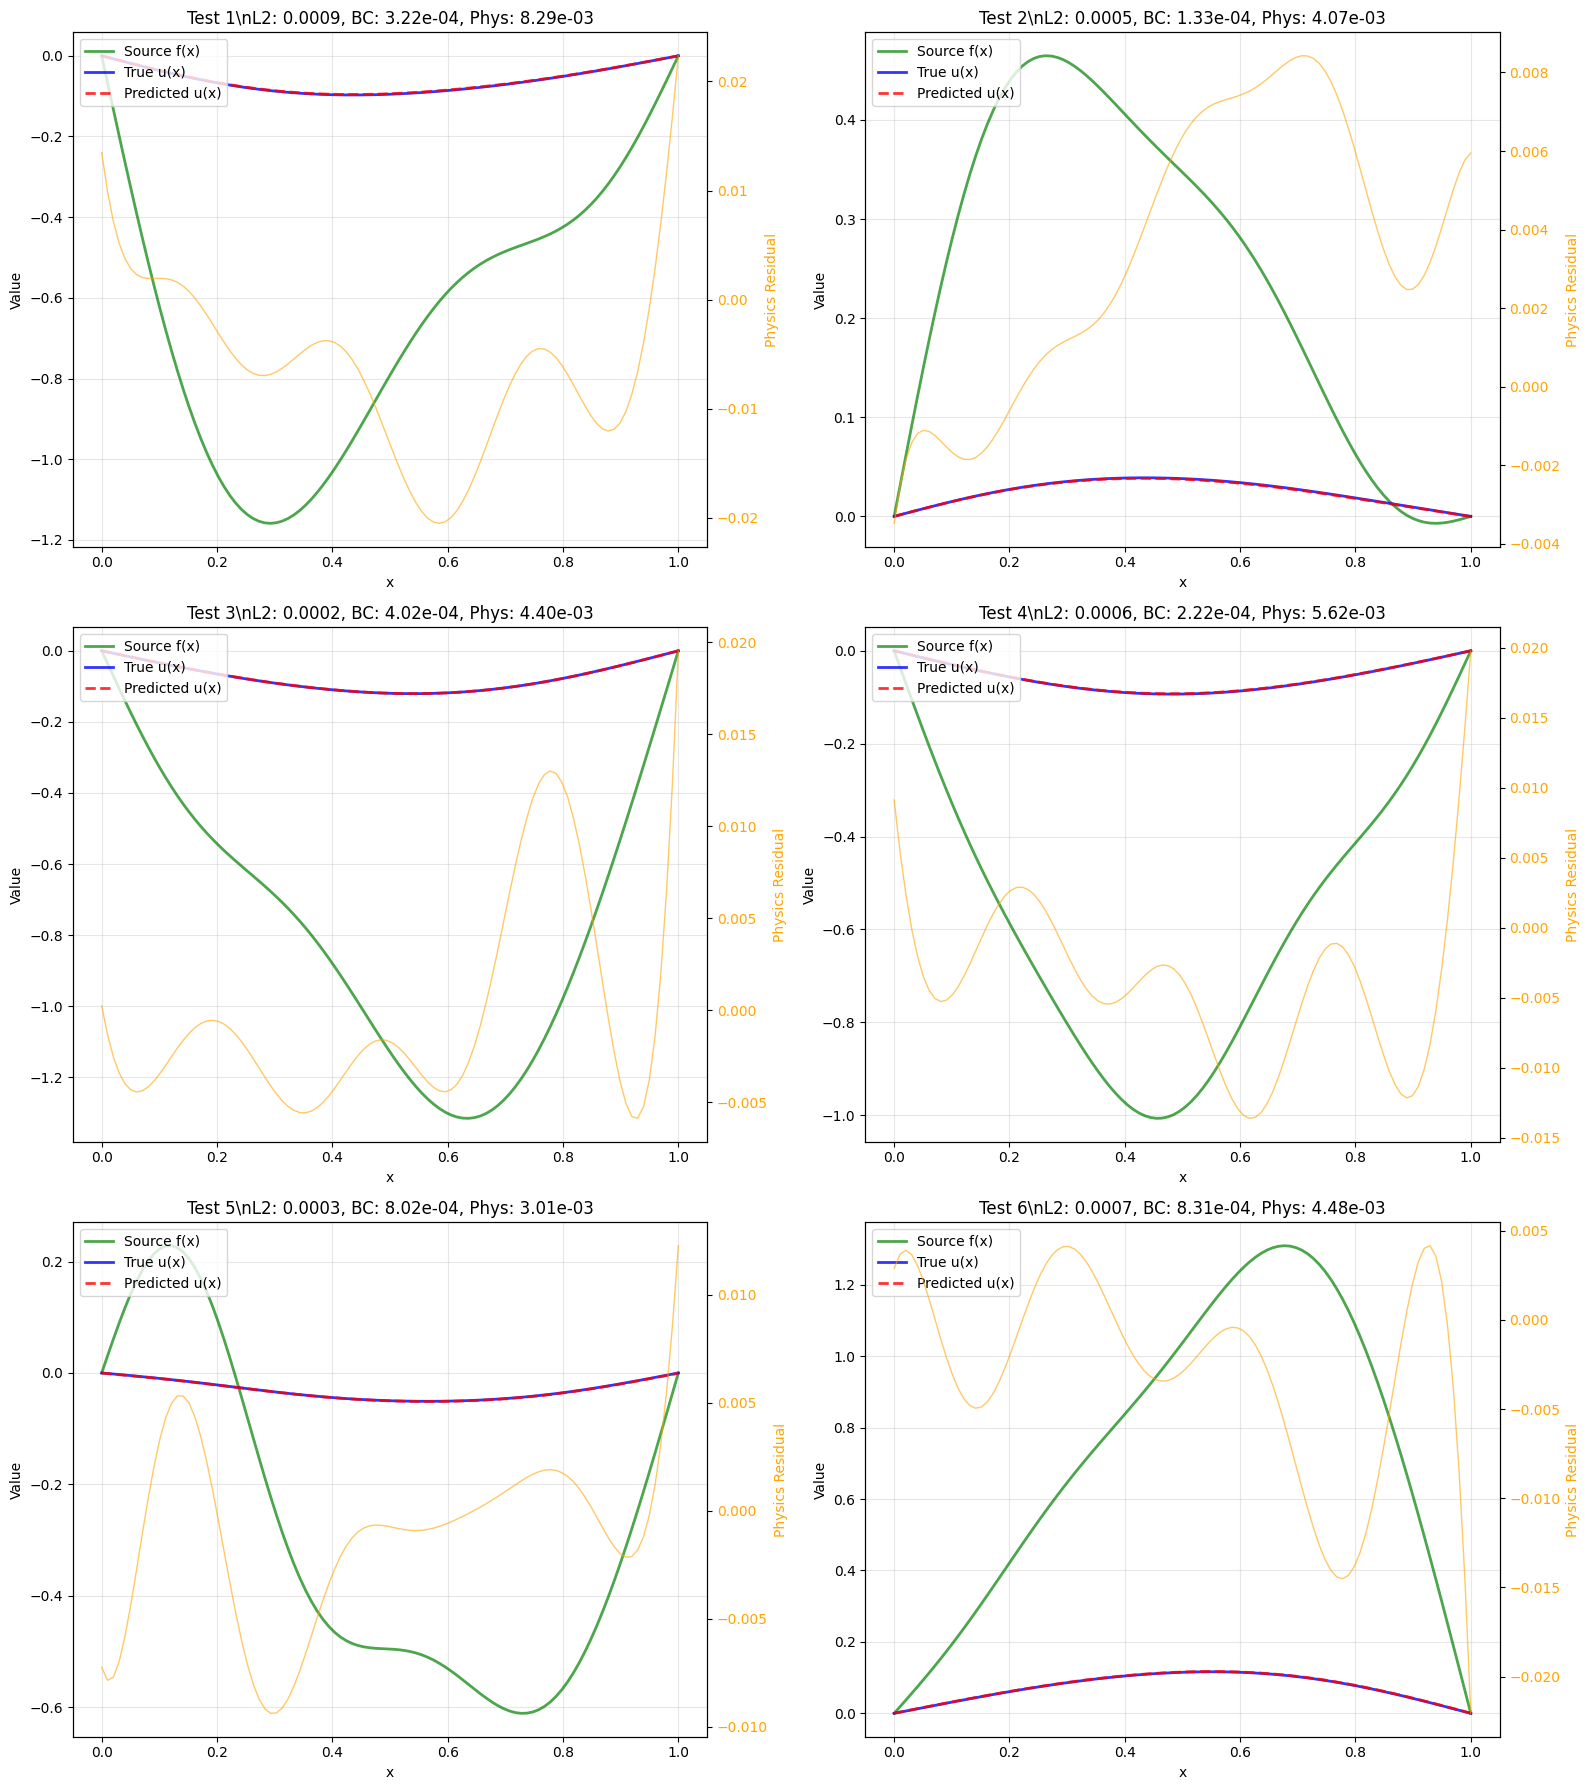

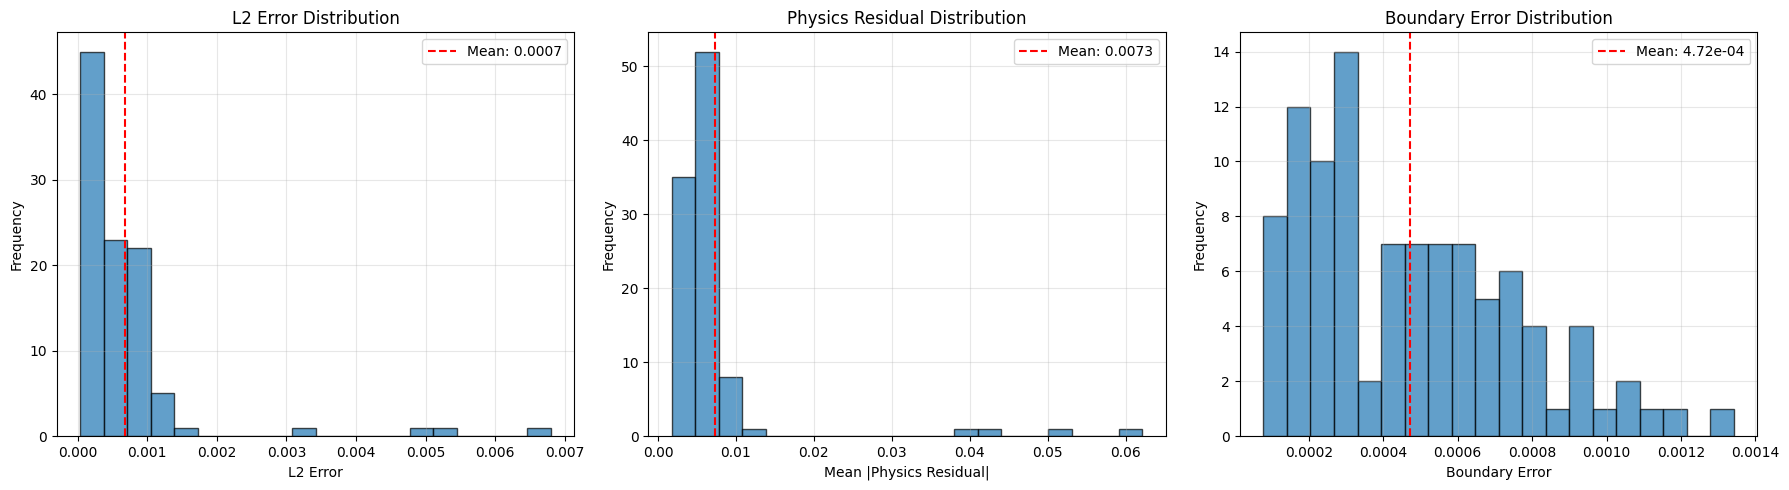

In [15]:
def evaluate_physics_informed_model(model, test_data, x):
    """Comprehensive evaluation of physics-informed DeepONet"""
    test_sources, test_solutions = test_data
    model.eval()
    
    n_test = len(test_sources)
    predictions = []
    physics_residuals = []
    boundary_errors = []
    l2_errors = []
    
    print(f"Evaluating {n_test} test samples...")
    
    # Don't use torch.no_grad() so we can compute derivatives
    for i in tqdm(range(n_test)):
        # Prepare input
        source_tensor = torch.tensor(test_sources[i:i+1], dtype=torch.float32).to(device)
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
        x_tensor = x_tensor.requires_grad_(True)
        
        # Predict solution and compute derivatives
        u_pred, du_dx, d2u_dx2 = model.compute_derivatives(source_tensor, x_tensor)
        
        # Convert to numpy
        u_pred_np = u_pred.detach().cpu().numpy().flatten()
        d2u_dx2_np = d2u_dx2.detach().cpu().numpy().flatten()
        
        predictions.append(u_pred_np)
        
        # Compute physics residual: d²u/dx² + f(x)
        physics_residual = d2u_dx2_np + test_sources[i]
        physics_residuals.append(physics_residual)
        
        # Compute boundary errors
        boundary_error = abs(u_pred_np[0]) + abs(u_pred_np[-1])  # |u(0)| + |u(1)|
        boundary_errors.append(boundary_error)
        
        # Compute L2 error
        l2_error = np.sqrt(np.mean((u_pred_np - test_solutions[i])**2))
        l2_errors.append(l2_error)
    
    # Statistics
    avg_l2_error = np.mean(l2_errors)
    avg_physics_residual = np.mean([np.mean(np.abs(res)) for res in physics_residuals])
    avg_boundary_error = np.mean(boundary_errors)
    
    print(f"\\nEvaluation Results:")
    print(f"  Average L2 Error: {avg_l2_error:.6f}")
    print(f"  Average Physics Residual: {avg_physics_residual:.6f}")
    print(f"  Average Boundary Error: {avg_boundary_error:.6f}")
    
    return predictions, physics_residuals, boundary_errors, l2_errors

print("\\n=== MODEL EVALUATION ===")
predictions, physics_residuals, boundary_errors, l2_errors = evaluate_physics_informed_model(
    pi_model, test_data, x
)

test_sources, test_solutions = test_data

# Visualization of results
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Plot sample predictions
for i in range(6):
    if i < 4:
        ax = axes[i//2, i%2]
    else:
        ax = axes[2, i-4]
    
    # Plot source, true solution, and prediction
    ax.plot(x, test_sources[i], 'g-', linewidth=2, label='Source f(x)', alpha=0.7)
    ax.plot(x, test_solutions[i], 'b-', linewidth=2, label='True u(x)', alpha=0.8)
    ax.plot(x, predictions[i], 'r--', linewidth=2, label='Predicted u(x)', alpha=0.8)
    
    # Plot physics residual
    ax2 = ax.twinx()
    ax2.plot(x, physics_residuals[i], 'orange', linewidth=1, alpha=0.6, label='Physics Residual')
    ax2.set_ylabel('Physics Residual', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Error metrics
    l2_err = l2_errors[i]
    bc_err = boundary_errors[i]
    phys_err = np.mean(np.abs(physics_residuals[i]))
    
    ax.set_title(f'Test {i+1}\\nL2: {l2_err:.4f}, BC: {bc_err:.2e}, Phys: {phys_err:.2e}')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# Error distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# L2 error distribution
axes[0].hist(l2_errors, bins=20, alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(l2_errors), color='red', linestyle='--', 
                label=f'Mean: {np.mean(l2_errors):.4f}')
axes[0].set_title('L2 Error Distribution')
axes[0].set_xlabel('L2 Error')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Physics residual distribution
physics_residual_means = [np.mean(np.abs(res)) for res in physics_residuals]
axes[1].hist(physics_residual_means, bins=20, alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(physics_residual_means), color='red', linestyle='--',
                label=f'Mean: {np.mean(physics_residual_means):.4f}')
axes[1].set_title('Physics Residual Distribution')
axes[1].set_xlabel('Mean |Physics Residual|')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Boundary error distribution
axes[2].hist(boundary_errors, bins=20, alpha=0.7, edgecolor='black')
axes[2].axvline(np.mean(boundary_errors), color='red', linestyle='--',
                label=f'Mean: {np.mean(boundary_errors):.2e}')
axes[2].set_title('Boundary Error Distribution')
axes[2].set_xlabel('Boundary Error')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison: Standard vs Physics-Informed DeepONet

### Comparative Analysis

Let's train a standard DeepONet (data-only) and compare it with our physics-informed version to understand the benefits of incorporating physics constraints.


=== TRAINING STANDARD DEEPONET FOR COMPARISON ===


Training Standard DeepONet:  29%|██▉       | 292/1000 [00:34<01:24,  8.36it/s, Train=3.14e-05, Val=2.29e-05, LR=5.00e-04]



Early stopping at epoch 292

Standard DeepONet training completed!
Final training loss: 3.14e-05
Final validation loss: 2.29e-05
Standard DeepONet - Average L2 Error: 0.004965


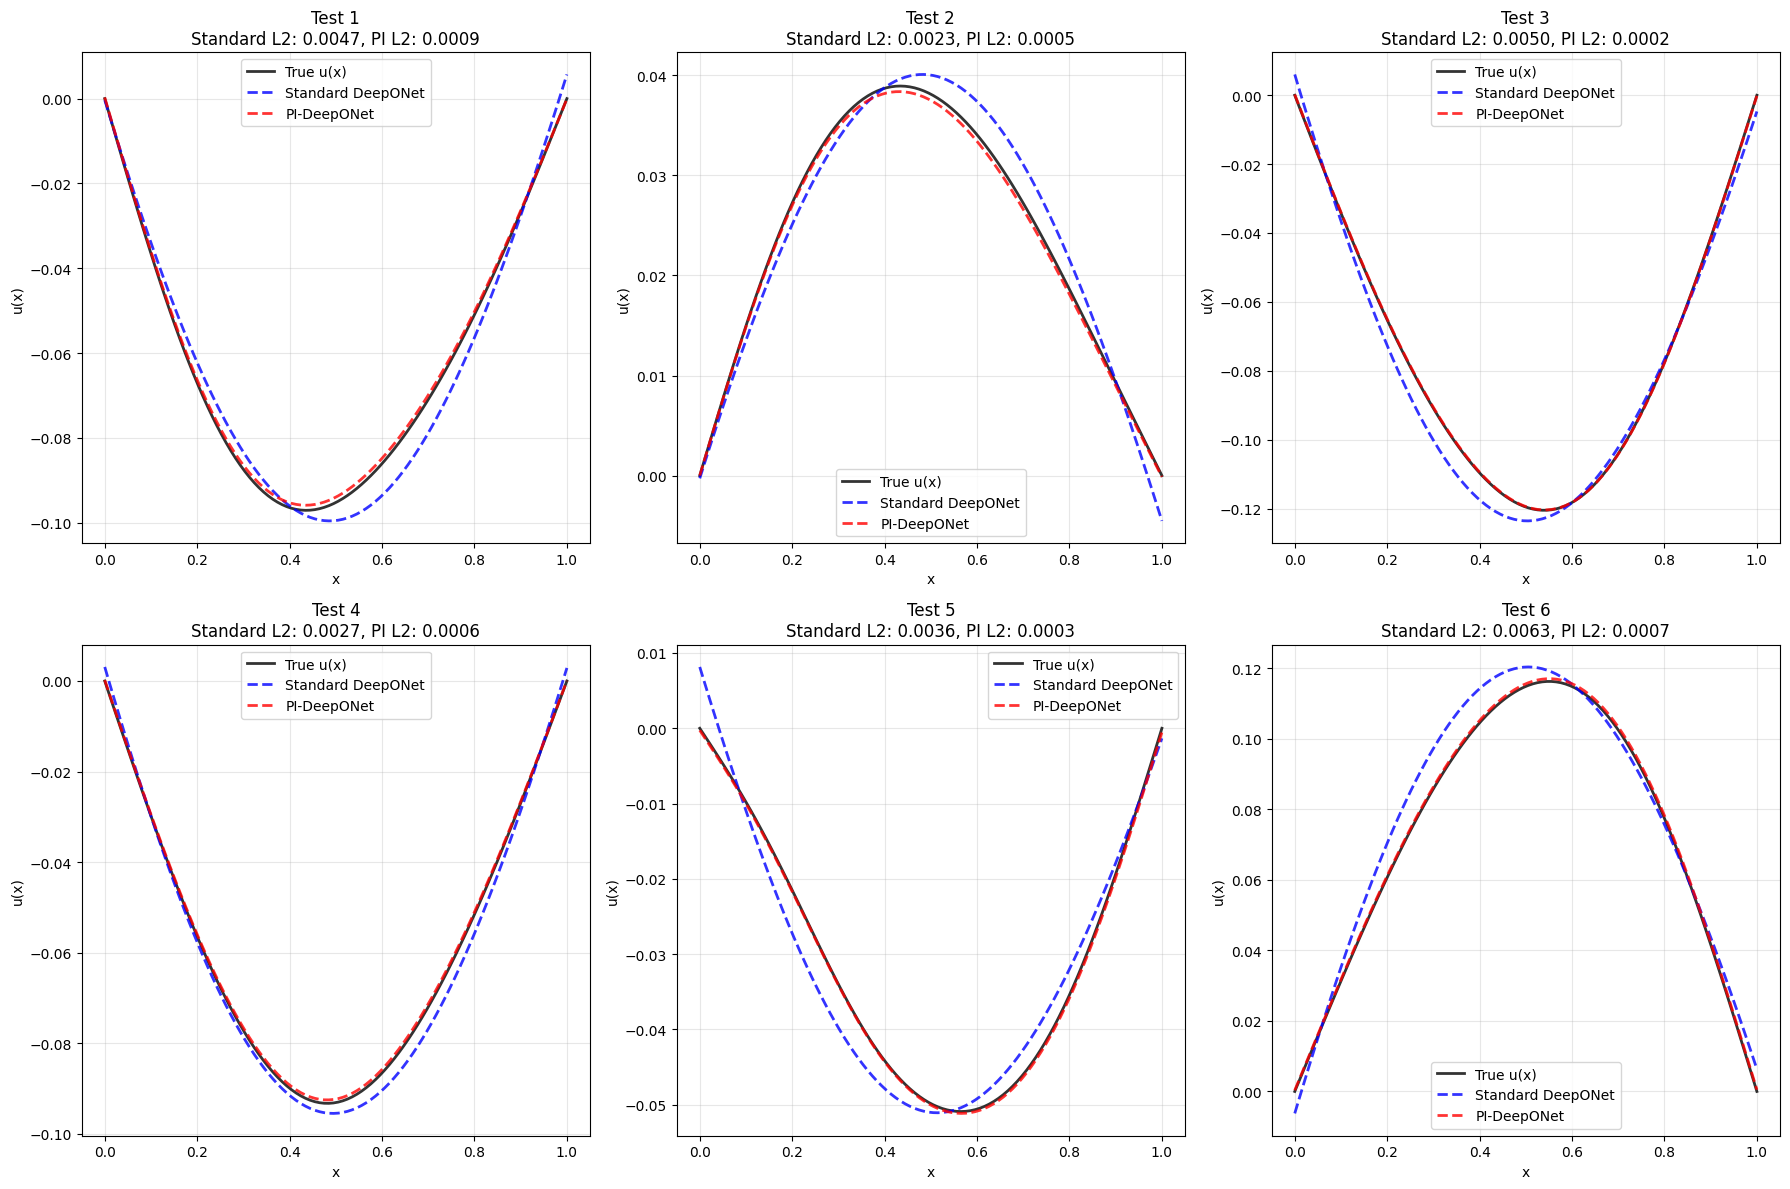


=== COMPARISON SUMMARY ===
Standard DeepONet:
  Mean L2 Error: 0.004965 ± 0.004721
  Final Training Loss: 3.14e-05

Physics-Informed DeepONet:
  Mean L2 Error: 0.000687 ± 0.000980
  Mean Physics Residual: 0.007279
  Mean Boundary Error: 0.000472
  Final Training Loss: 1.10e-04

Improvement: 86.2% reduction in L2 error


In [16]:
# Train standard DeepONet for comparison
print("\n=== TRAINING STANDARD DEEPONET FOR COMPARISON ===")

# Create standard DeepONet (same architecture, different training)
standard_model = PhysicsInformedDeepONet(
    branch_input_dim=len(x),
    trunk_input_dim=1,
    hidden_dim=64,
    num_basis=50
).to(device)

# Train with data loss only
def train_standard_deeponet(model, train_loader, val_loader, num_epochs=1000, lr=0.001):
    """Train standard DeepONet with data loss only"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience = 200
    patience_counter = 0
    
    pbar = tqdm(range(num_epochs), desc="Training Standard DeepONet")
    
    for epoch in pbar:
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_sources, batch_x, batch_solutions in train_loader:
            batch_sources = batch_sources.to(device)
            batch_x = batch_x.to(device)
            batch_solutions = batch_solutions.to(device)
            
            optimizer.zero_grad()
            
            # Only data loss
            u_pred = model(batch_sources, batch_x)
            loss = torch.mean((u_pred - batch_solutions)**2)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_sources, batch_x, batch_solutions in val_loader:
                batch_sources = batch_sources.to(device)
                batch_x = batch_x.to(device)
                batch_solutions = batch_solutions.to(device)
                
                u_pred = model(batch_sources, batch_x)
                loss = torch.mean((u_pred - batch_solutions)**2)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        pbar.set_postfix({
            'Train': f'{avg_train_loss:.2e}',
            'Val': f'{avg_val_loss:.2e}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch}')
                break
    
    pbar.close()
    return train_losses, val_losses

# Train standard model
standard_train_losses, standard_val_losses = train_standard_deeponet(
    standard_model, train_loader, val_loader, num_epochs=1000, lr=0.001
)

print("\nStandard DeepONet training completed!")
print(f"Final training loss: {standard_train_losses[-1]:.2e}")
print(f"Final validation loss: {standard_val_losses[-1]:.2e}")

# Evaluate standard model
def evaluate_standard_model(model, test_data, x):
    """Evaluate standard DeepONet"""
    test_sources, test_solutions = test_data
    model.eval()
    
    predictions = []
    l2_errors = []
    
    with torch.no_grad():
        for i in range(len(test_sources)):
            source_tensor = torch.tensor(test_sources[i:i+1], dtype=torch.float32).to(device)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
            
            u_pred = model(source_tensor, x_tensor)
            u_pred_np = u_pred.cpu().numpy().flatten()
            
            predictions.append(u_pred_np)
            
            l2_error = np.sqrt(np.mean((u_pred_np - test_solutions[i])**2))
            l2_errors.append(l2_error)
    
    avg_l2_error = np.mean(l2_errors)
    print(f"Standard DeepONet - Average L2 Error: {avg_l2_error:.6f}")
    
    return predictions, l2_errors

standard_predictions, standard_l2_errors = evaluate_standard_model(standard_model, test_data, x)

# Comparative visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(6):
    ax = axes[i//3, i%3]
    
    # Plot true solution and both predictions
    ax.plot(x, test_solutions[i], 'k-', linewidth=2, label='True u(x)', alpha=0.8)
    ax.plot(x, standard_predictions[i], 'b--', linewidth=2, label='Standard DeepONet', alpha=0.8)
    ax.plot(x, predictions[i], 'r--', linewidth=2, label='PI-DeepONet', alpha=0.8)
    
    # Error comparison
    std_err = standard_l2_errors[i]
    pi_err = l2_errors[i]
    
    ax.set_title(f'Test {i+1}\nStandard L2: {std_err:.4f}, PI L2: {pi_err:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== COMPARISON SUMMARY ===")
print(f"Standard DeepONet:")
print(f"  Mean L2 Error: {np.mean(standard_l2_errors):.6f} ± {np.std(standard_l2_errors):.6f}")
print(f"  Final Training Loss: {standard_train_losses[-1]:.2e}")

print(f"\nPhysics-Informed DeepONet:")
print(f"  Mean L2 Error: {np.mean(l2_errors):.6f} ± {np.std(l2_errors):.6f}")
print(f"  Mean Physics Residual: {np.mean([np.mean(np.abs(res)) for res in physics_residuals]):.6f}")
print(f"  Mean Boundary Error: {np.mean(boundary_errors):.6f}")
print(f"  Final Training Loss: {train_losses['total'][-1]:.2e}")

# Improvement metrics
l2_improvement = (np.mean(standard_l2_errors) - np.mean(l2_errors)) / np.mean(standard_l2_errors) * 100
print(f"\nImprovement: {l2_improvement:.1f}% reduction in L2 error")

## Summary and Key Insights

### What We've Accomplished

1. **Physics-Informed DeepONet:** Successfully implemented PI-DeepONet for 1D Poisson equation
2. **Multi-objective Training:** Balanced data fidelity, physics consistency, and boundary conditions
3. **Comprehensive Evaluation:** Analyzed prediction accuracy, physics satisfaction, and boundary compliance
4. **Comparative Analysis:** Demonstrated advantages over standard data-driven approach

### Key Advantages of Physics-Informed DeepONet

✅ **Enhanced Generalization:** Physics constraints help the model generalize better to unseen data

✅ **Boundary Condition Enforcement:** Soft constraints ensure boundary conditions are satisfied

✅ **Physical Consistency:** Solutions automatically satisfy the governing PDE

✅ **Reduced Data Requirements:** Physics knowledge compensates for limited training data

✅ **Interpretable Learning:** Physics loss components provide insight into learning dynamics

### Architecture Highlights

- **Automatic Differentiation:** PyTorch's autograd enables seamless derivative computation
- **Soft Constraints:** Physics and boundary conditions are enforced through loss terms
- **Multi-scale Training:** Different loss components learn at different scales
- **Flexible Framework:** Easily adaptable to other PDEs and boundary conditions

### Applications and Extensions

**Immediate Extensions:**
- **Different Boundary Conditions:** Neumann, Robin, or periodic boundaries
- **Higher Dimensions:** 2D/3D Poisson equations
- **Time-dependent PDEs:** Parabolic and hyperbolic equations
- **Nonlinear PDEs:** Variable coefficients and nonlinear source terms

**Advanced Applications:**
- **Inverse Problems:** Learning unknown parameters from data
- **Multi-physics:** Coupled PDE systems
- **Uncertainty Quantification:** Bayesian neural operators
- **Real-time Control:** Fast PDE-constrained optimization

### Best Practices

1. **Loss Balancing:** Carefully tune λ_physics and λ_boundary weights
2. **Sampling Strategy:** Use sufficient collocation points for physics loss
3. **Architecture Design:** Match network capacity to problem complexity
4. **Training Monitoring:** Track all loss components separately
5. **Validation:** Always verify physics satisfaction on test data

---

**Physics-informed DeepONet represents a powerful paradigm that combines the flexibility of neural networks with the rigor of physical laws, opening new possibilities for scientific machine learning and computational physics.**